## ARIMA Model Development

#### Introduction to ARIMA
The ARIMA (Autoregressive Integrated Moving Average) model is a popular statistical method used for time series forecasting. It is suitable for data that shows evidence of non-stationarity, where differencing can help achieve stationarity. ARIMA models capture the relationship between an observation and a number of lagged observations, along with lagged errors.

#### Data Preparation and Splitting
The dataset is split into training and testing sets. The features are separated from the target variable `TotalPrice`. This step ensures that we have distinct datasets for training the model and evaluating its performance.

In [25]:
import pandas as pd
import numpy as np
import itertools
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

def split_data(data):
    # Define your features and target variable
    X = data.drop(['TotalPrice', 'InvoiceDate'], axis=1)
    y = data['TotalPrice']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

#### Hyperparameter Tuning for ARIMA
The `tune_arima function` iterates over a range of parameters to find the best ARIMA model based on the Akaike Information Criterion (AIC). The AIC is a measure of model quality that balances goodness of fit and model complexity. The function returns the best model along with its order.

In [26]:
def tune_arima(y_train):
    p = d = q = range(0, 3)  
    pdq = list(itertools.product(p, d, q))

    best_aic = float("inf")
    best_order = None
    best_model = None

    warnings.filterwarnings("ignore")

    for param in pdq:
        try:
            model = ARIMA(y_train, order=param)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = param
                best_model = results
        except Exception as e:
            continue

    print(f'Best ARIMA order: {best_order}')
    print(f'Best ARIMA model AIC: {best_aic}')
    return best_model, best_order

#### Model Validation
The `validate_model` function evaluates the ARIMA model's performance on the test set. It calculates various metrics such as Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Scaled Error (MASE), and Weighted Mean Absolute Percentage Error (WMAPE). These metrics provide insights into the model's accuracy and robustness.

In [27]:
def validate_model(model, y_test):
    predictions = model.forecast(steps=len(y_test))

    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mase = mae / np.mean(np.abs(np.diff(y_test)))
    wmape = np.sum(np.abs(predictions - y_test)) / np.sum(y_test)

    metrics = {
        'MAE (Total)': mae,
        'RMSE (Total)': rmse,
        'MASE (Total)': mase,
        'WMAPE (Total)': wmape
    }
    return metrics, predictions

#### Diagnostic Check
The `diagnostic_check` function plots the true values against the predicted values to visually inspect the ARIMA model's performance. This helps in identifying any patterns or discrepancies between the actual and predicted data.

In [28]:
def diagnostic_check(y_test, predictions):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label='True Values')
    plt.plot(predictions, label='Predictions')
    plt.title('ARIMA Model - True vs Predictions')
    plt.xlabel('Time')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Seasonal Decomposition
The `decompose_seasonal_component` function decomposes the seasonal component of the time series data using STL decomposition.

In [29]:
def decompose_seasonal_component(data):
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    data.set_index('InvoiceDate', inplace=True)
    daily_sales = data['TotalPrice'].resample('D').sum().fillna(0)
    stl = STL(daily_sales, seasonal=7)
    result = stl.fit()
    return result

#### Calculate Seasonal Metrics
The `calculate_seasonal_metrics` function calculates the seasonal MAE and RMSE for the model's predictions.

In [30]:
def calculate_seasonal_metrics(model, y_test, seasonal_component):
    predictions = model.forecast(steps=len(y_test))

    if len(predictions) > len(seasonal_component):
        predictions = predictions[:len(seasonal_component)]
    else:
        seasonal_component = seasonal_component[:len(predictions)]

    smae = mean_absolute_error(seasonal_component, predictions)
    srmse = np.sqrt(mean_squared_error(seasonal_component, predictions))

    seasonal_metrics = {
        'MAE (Seasonal)': smae,
        'RMSE (Seasonal)': srmse
    }

    return seasonal_metrics

#### Plot Seasonal Comparisons
The `plot_seasonal_comparisons` function plots the true seasonal component against the model's predicted seasonal component.

In [31]:
def plot_seasonal_comparisons(y_test, predictions, seasonal_component):
    if len(seasonal_component) > len(y_test):
        seasonal_component = seasonal_component[-len(y_test):]
    if len(predictions) > len(seasonal_component):
        predictions = predictions[-len(seasonal_component):]

    plt.figure(figsize=(12, 6))
    plt.plot(range(len(seasonal_component)), seasonal_component, label='True Seasonal')
    plt.plot(range(len(predictions)), predictions, label='Predicted Seasonal')
    plt.title('True vs Predicted Seasonal Components')
    plt.xlabel('Time')
    plt.ylabel('Total Sales')
    plt.legend()
    plt.grid(True)
    plt.show()

#### Plot Seasonal Decomposition
The `plot_seasonal_decomposition` function plots the components of the STL decomposition.

In [32]:

def plot_seasonal_decomposition(stl_result):
    stl_result.plot()
    plt.show()

#### Main Function
The `main_arima` function orchestrates the data splitting, model training, validation, and seasonal analysis. It also logs the chosen hyperparameters and the calculated performance metrics.

Best ARIMA order: (0, 2, 2)
Best ARIMA model AIC: 428328.4231438317
Chosen hyperparameters: (0, 2, 2)


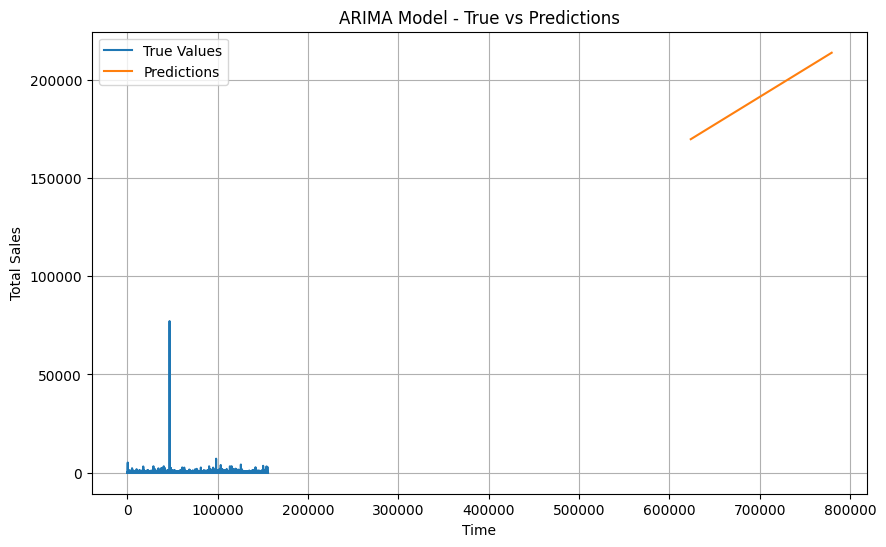

Seasonal Metrics: {'MAE (Seasonal)': 169780.31476223032, 'RMSE (Seasonal)': 170236.87461978616}


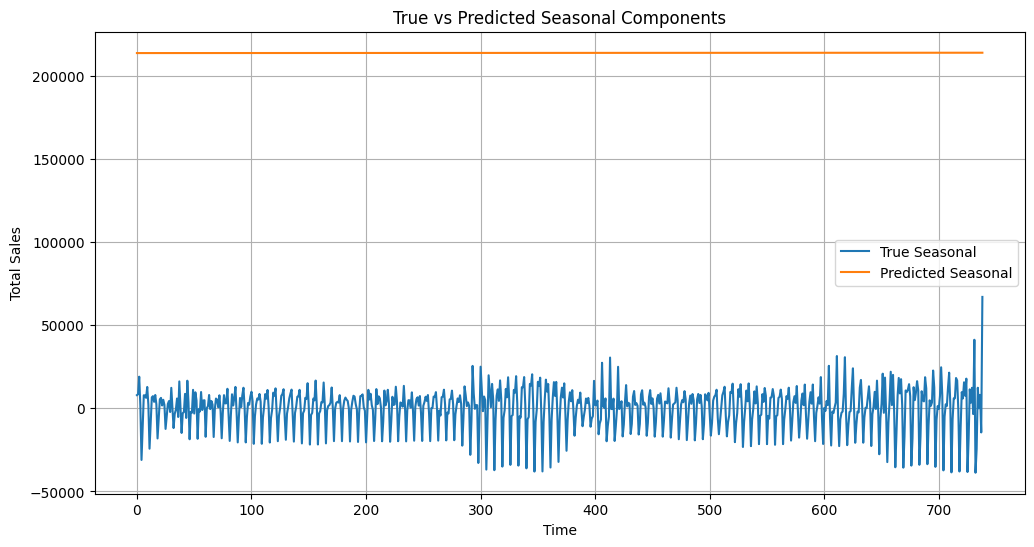

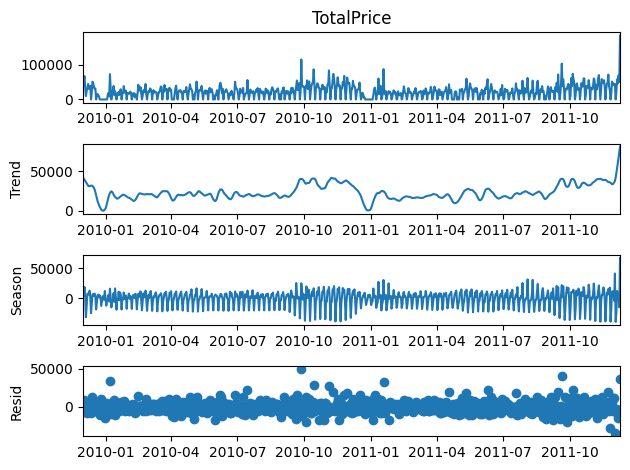

Model performance metrics updated and saved to model_performance_metrics.csv


In [33]:
def main_arima(file_path, metrics_df_path):
    data = pd.read_csv(file_path)
    X_train, X_test, y_train, y_test = split_data(data)

    stl_result = decompose_seasonal_component(data)
    seasonal_component = stl_result.seasonal[-len(y_test):]  # Align with the length of y_test

    best_arima_model, best_order = tune_arima(y_train)
    print(f'Chosen hyperparameters: {best_order}')
    metrics, predictions = validate_model(best_arima_model, y_test)
    diagnostic_check(y_test, predictions)

    seasonal_metrics = calculate_seasonal_metrics(best_arima_model, y_test, seasonal_component)
    print(f'Seasonal Metrics: {seasonal_metrics}')
    plot_seasonal_comparisons(y_test, predictions, seasonal_component)
    plot_seasonal_decomposition(stl_result)

    # Load or create a metrics DataFrame
    try:
        metrics_df = pd.read_csv(metrics_df_path)
    except FileNotFoundError:
        metrics_df = pd.DataFrame(columns=['Model', 'MAE (Total)', 'RMSE (Total)', 'MASE (Total)', 'WMAPE (Total)', 'MAE (Seasonal)', 'RMSE (Seasonal)'])

    metrics.update(seasonal_metrics)
    metrics['Model'] = 'ARIMA'
    metrics_df = metrics_df.append(metrics, ignore_index=True)

    # Save the updated metrics DataFrame
    metrics_df.to_csv(metrics_df_path, index=False)
    print('Model performance metrics updated and saved to', metrics_df_path)

# Read data and output model metrics
file_path = 'preprocessed_data.csv'
metrics_df_path = 'model_performance_metrics.csv'
main_arima(file_path, metrics_df_path)
